In [21]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from datetime import date
from datetime import time
from sklearn.cluster import KMeans

from datetime import datetime as dt

In [2]:
order_detail_df = pd.read_excel("data/order.xlsx", parse_dates = ['Ngày phát sinh'])
user_df = pd.read_excel("data/user.xlsx")
listening_detail_df = pd.read_excel("data/listening.xlsx")

In [4]:
# Chuyển User_ID và Order_ID, Playlist ID sang category
order_detail_df['Order ID'] = order_detail_df['Order ID'].astype('category')
order_detail_df['ID của user'] = order_detail_df['ID của user'].astype('category')

user_df['User ID'] = user_df['User ID'].astype('category')

listening_detail_df['Playlist ID']=listening_detail_df['Playlist ID'].astype('category')
listening_detail_df['User ID']=listening_detail_df['User ID'].astype('category')

# usage_df['User ID']=usage_df['User ID'].astype('category')

In [3]:
# Chuyển Ngày phát sinh lượt nghe sang kiểu dữ liệu date
listening_detail_df["Ngày phát sinh lượt nghe"] = listening_detail_df["Ngày phát sinh lượt nghe"].map(
                                        lambda x:date(int(x.split("-")[2]),int(x.split("-")[1]),int(x.split("-")[0])))
listening_detail_df["Ngày phát sinh lượt nghe"] = listening_detail_df["Ngày phát sinh lượt nghe"].astype("datetime64")

In [4]:
order_summary_df = order_detail_df.groupby('ID của user').agg({'Ngày phát sinh': ['min',"max"]}).reset_index()
order_summary_df.columns = ['User_ID','min_purchase_date',"max_purchase_date"]

In [5]:
listening_summary_df = listening_detail_df.groupby('User ID').agg({"Ngày phát sinh lượt nghe":['min','max','count']}).reset_index()
listening_summary_df.columns = ['User_ID','first_listen_date','last_listen_date','listen_cnt']

### Cắt nhỏ giá trị ngày nghe

In [6]:
##### Cắt nhỏ giá trị order_date

listening_detail_df['listen_year'] = listening_detail_df['Ngày phát sinh lượt nghe'].map(lambda x: x.strftime('%Y'))
listening_detail_df['listen_month'] = listening_detail_df['Ngày phát sinh lượt nghe'].map(lambda x: x.strftime('%m'))
listening_detail_df['listen_day'] = listening_detail_df['Ngày phát sinh lượt nghe'].map(lambda x: x.strftime('%d'))

In [7]:
listening_detail_df['listen_month_year'] = listening_detail_df['Ngày phát sinh lượt nghe'].map(lambda x: x.strftime('%m/%Y'))

### Calculate những dữ liệu để phân tích ROLLRATE

In [8]:
# Chỉ xem những users có nghe và orders
# Lấy user_id từ 2 bảng order_summary_df và listening_summary_df gộp vào 1 bảng
user_cluster_df= pd.DataFrame(pd.concat(objs=[listening_summary_df['User_ID'],order_summary_df['User_ID']]).drop_duplicates().reset_index(drop=True))
user_cluster_df.columns = ["User_ID"]
user_cluster_df.shape[0]

27458

In [9]:
## Lấy ngày signup date
user_cluster_df = user_cluster_df.join(user_df[["User ID","Ngày đăng ký tài khoản"]].set_index("User ID"),
                                       on="User_ID",how="inner")
user_cluster_df = user_cluster_df.rename(columns = {'Ngày đăng ký tài khoản':'signup_date'})

# Tất cả các user đều có ngày sign up

In [10]:
## Lấy ngày đổi trạng thái

user_cluster_df = user_cluster_df.join(other=order_summary_df[["User_ID","min_purchase_date","max_purchase_date"]].set_index('User_ID'),how='left',on='User_ID')

In [11]:
## Lấy ngày nghe đầu tiên và cuối cùng
user_cluster_df= user_cluster_df.join(other=listening_summary_df[["User_ID","first_listen_date","last_listen_date"]].set_index('User_ID'),how='left',on='User_ID')

In [12]:
user_cluster_df.head(1)

,User_ID,signup_date,min_purchase_date,max_purchase_date,first_listen_date,last_listen_date
0,40834,2020-07-01,NaT,NaT,2020-07-08,2020-07-08


## Tính số lượt nghe mỗi tháng

In [13]:
cnt_df = listening_detail_df[["User ID","listen_month_year"]]
h = pd.crosstab(index=cnt_df["User ID"],columns=cnt_df.listen_month_year,dropna=False)
user_cluster_df=user_cluster_df.join(h,how="left",on="User_ID")
month_bins = np.sort(cnt_df.listen_month_year.unique())

user_cluster_df.head(3)

,User_ID,signup_date,min_purchase_date,max_purchase_date,first_listen_date,last_listen_date,07/2020,08/2020,09/2020,10/2020,11/2020,12/2020
0,40834,2020-07-01,NaT,NaT,2020-07-08,2020-07-08,2.0,0.0,0.0,0.0,0.0,0.0
1,40835,2020-07-01,NaT,NaT,2020-09-02,2020-10-07,0.0,0.0,4.0,1.0,0.0,0.0
2,40839,2020-07-01,NaT,NaT,2020-07-21,2020-10-11,28.0,24.0,3.0,5.0,0.0,0.0


In [132]:
# user_cluster_df=user_cluster_df.drop(columns = month_bins, axis=1)

In [140]:
# month_bins=np.sort(cnt_df.listen_month_year.unique())

In [14]:
user_cluster_df[month_bins].describe()

,07/2020,08/2020,09/2020,10/2020,11/2020,12/2020
count,27183.000000,27183.000000,27183.000000,27183.000000,27183.000000,27183.000000
mean,0.609683,2.027333,2.876504,4.589560,7.591473,9.899827
std,6.523314,11.485216,14.931286,19.076747,24.720837,28.030310
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,4.000000,6.000000
max,368.000000,481.000000,515.000000,462.000000,841.000000,627.000000


In [22]:
## Change Status
# user_cluster_df["min_purchase_date"] = user_cluster_df.change_status_date
# user_cluster_df.change_status_date = user_cluster_df["min_purchase_date"].map(lambda x: x.strftime('%m/%Y'))
user_cluster_df.change_status_date = user_cluster_df["min_purchase_date"].dt.strftime('%m/%Y')
user_cluster_df.tail(5)

<ipython-input-22-fb33fb59e0ab>:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  user_cluster_df.change_status_date = user_cluster_df["min_purchase_date"].dt.strftime('%m/%Y')


,User_ID,signup_date,min_purchase_date,max_purchase_date,first_listen_date,last_listen_date,07/2020,08/2020,09/2020,10/2020,11/2020,12/2020,1_listen_my,signup_date
27453,106773,2020-12-31,2020-12-31,2020-12-31,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31
27454,106960,2020-12-31,2020-12-31,2020-12-31,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31
27455,106971,2020-12-31,2020-12-31,2020-12-31,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31
27456,106974,2020-12-31,2020-12-31,2020-12-31,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31
27457,106981,2020-12-31,2020-12-31,2020-12-31,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31


In [23]:
user_cluster_df["1_listen_my"] = user_cluster_df["first_listen_date"].dt.strftime('%m/%Y')

In [24]:
user_cluster_df.tail(3)

,User_ID,signup_date,min_purchase_date,max_purchase_date,first_listen_date,last_listen_date,07/2020,08/2020,09/2020,10/2020,11/2020,12/2020,1_listen_my,signup_date
27455,106971,2020-12-31,2020-12-31,2020-12-31,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31
27456,106974,2020-12-31,2020-12-31,2020-12-31,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31
27457,106981,2020-12-31,2020-12-31,2020-12-31,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31


In [ ]:
### Xét các chỉ số frequency của các tháng

In [46]:
user_cluster_df.dtypes

User_ID                       int64
min_purchase_date    datetime64[ns]
max_purchase_date    datetime64[ns]
first_listen_date    datetime64[ns]
last_listen_date     datetime64[ns]
07/2020                     float64
08/2020                     float64
09/2020                     float64
10/2020                     float64
11/2020                     float64
12/2020                     float64
1_listen_my                  object
dtype: object

In [45]:
# user_cluster_df=user_cluster_df.drop(columns =["signup_date"],axis=1)

In [47]:
user_cluster_df=user_cluster_df.join(user_df[["User ID",'Ngày đăng ký tài khoản']].set_index("User ID"),on="User_ID",how="inner")

In [48]:
user_cluster_df=user_cluster_df.rename(columns={'Ngày đăng ký tài khoản':"signup_date"})

In [49]:
type(user_cluster_df["signup_date"])

pandas.core.series.Series

In [50]:
user_cluster_df["signup_my"] = user_cluster_df["signup_date"].dt.strftime('%m/%Y')
user_cluster_df["change_status_my"] = user_cluster_df["min_purchase_date"].dt.strftime('%m/%Y')

In [51]:
user_cluster_df.columns

Index(['User_ID', 'min_purchase_date', 'max_purchase_date',
       'first_listen_date', 'last_listen_date', '07/2020', '08/2020',
       '09/2020', '10/2020', '11/2020', '12/2020', '1_listen_my',
       'signup_date', 'signup_my', 'change_status_my'],
      dtype='object')

In [52]:
user_cluster_df[month_bins].describe()

,07/2020,08/2020,09/2020,10/2020,11/2020,12/2020
count,27183.000000,27183.000000,27183.000000,27183.000000,27183.000000,27183.000000
mean,0.609683,2.027333,2.876504,4.589560,7.591473,9.899827
std,6.523314,11.485216,14.931286,19.076747,24.720837,28.030310
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,4.000000,6.000000
max,368.000000,481.000000,515.000000,462.000000,841.000000,627.000000


In [53]:
rollrate_df = user_cluster_df[~user_cluster_df["first_listen_date"].isnull()]

In [ ]:
## Tính free user tháng 07/2020

In [54]:
for col in month_bins:
    rollrate_df["cnt_"+col]=rollrate_df.loc[:,str(col)].map(lambda x: np.nan if x==0 else x)

<ipython-input-54-ed7f0360ec71>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rollrate_df["cnt_"+col]=rollrate_df.loc[:,str(col)].map(lambda x: np.nan if x==0 else x)


In [55]:
rollrate_df["cnt_"+month_bins].describe()

,cnt_07/2020,cnt_08/2020,cnt_09/2020,cnt_10/2020,cnt_11/2020,cnt_12/2020
count,823.000000,3395.000000,4127.000000,6695.000000,10314.000000,12433.000000
mean,20.137303,16.232401,18.946450,18.634503,20.007659,21.644575
std,31.834836,28.736687,34.120425,34.871219,36.909173,38.257847
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,2.000000,2.000000,2.000000,3.000000,3.000000
50%,8.000000,6.000000,7.000000,7.000000,7.000000,8.000000
75%,24.000000,18.000000,21.000000,19.000000,22.000000,24.000000
max,368.000000,481.000000,515.000000,462.000000,841.000000,627.000000


In [71]:
# for col in month_bins:
#     rollrate_df["F_"+month_bins] = round(rollrate_df["cnt_"+month_bins]/30,2)

In [57]:
rollrate_df.columns

Index(['User_ID', 'min_purchase_date', 'max_purchase_date',
       'first_listen_date', 'last_listen_date', '07/2020', '08/2020',
       '09/2020', '10/2020', '11/2020', '12/2020', '1_listen_my',
       'signup_date', 'signup_my', 'change_status_my', 'cnt_07/2020',
       'cnt_08/2020', 'cnt_09/2020', 'cnt_10/2020', 'cnt_11/2020',
       'cnt_12/2020'],
      dtype='object')

In [71]:
frequence = rollrate_df['cnt_07/2020'].dropna()

for i in range(1,len(month_bins)):
    t = rollrate_df["cnt_"+month_bins[i]].dropna()
    frequence = pd.concat([frequence, t])
    
frequence.shape[0]
frequence = frequence.unique()

37787

In [80]:

frequence_df=pd.DataFrame(data=frequence,columns=['frequence'])
frequence_df.shape[0]

345

<AxesSubplot:xlabel='frequence'>

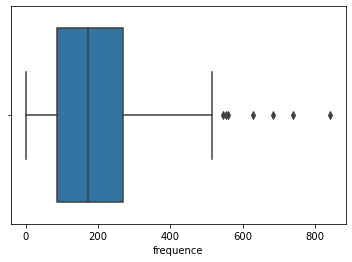

In [81]:
sns.boxplot(x=frequence_df['frequence'])

In [146]:
q99 =frequence_df["frequence"].quantile(0.95) 

frequence_df["frequence"] = frequence_df["frequence"].map(lambda x: q99 if x>q99 else x)

<AxesSubplot:xlabel='frequence'>

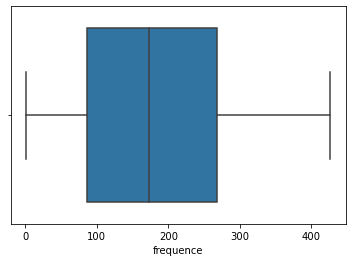

In [147]:
sns.boxplot(x=frequence_df['frequence'])

In [148]:
frequence_df.describe()

,frequence,clusters,frequenceCluster
count,345.000000,345.000000,345.000000
mean,185.707362,4.095652,1.040580
std,118.880767,2.683847,0.926722
min,1.000000,0.000000,0.000000
25%,87.000000,1.000000,0.000000
50%,173.000000,4.000000,1.000000
75%,268.000000,7.000000,2.000000
max,426.280000,8.000000,3.000000


In [149]:
def find_sse(df, max_k):
    sse = {}
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k, max_iter=1000)
        kmeans.fit(df)
        df['clusters'] = kmeans.labels_
        sse[k] = kmeans.inertia_
    return sse
   
## function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final
def run_kmean_clustering(df,cluster_cols,k_cluster,k_iter = 1000):
    kmeans = KMeans(n_clusters=k_cluster, max_iter = k_iter )
    kmeans.fit(df[cluster_cols])
    prefix = cluster_cols[0]
    df[str(prefix)+"Cluster"]= kmeans.predict((df[cluster_cols]))
    return df

def min_max_scale(df,scale_cols):
    for col in scale_cols:
        min_val = df[col].min()
        max_val = df[col].max()
        distance = max_val - min_val
        df['scaled'+str(col)] = (df[col]-min_val)/distance
    return df


In [150]:
fre_old=frequence_df.copy()

In [120]:
# fre = min_max_scale(fre,["frequence"])

C:\Users\Hara Nguyen\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


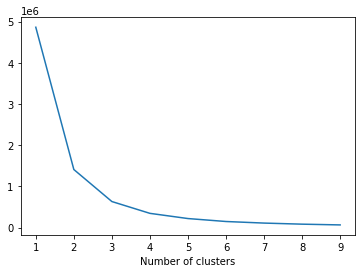

In [151]:
#Clustering:
## Elbow Method to determine K
sse = find_sse(frequence_df, max_k = 10) 

plt.figure()
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel("Number of clusters")
plt.show() 

# # Optimal R_K=3

In [152]:
# ## RecencyCluster_k = 3
k_clus = 4
frequence_df = run_kmean_clustering(frequence_df,["frequence"],k_cluster=k_clus)

## Sắp theo thứ tự R càng thấp thì Cluster càng cao
frequence_df = order_cluster('frequenceCluster', 'frequence',frequence_df,True)
frequence_df.groupby("frequenceCluster")['frequence'].describe()

# ## see details of each cluster - Recency

,count,mean,std,min,25%,50%,75%,max
frequenceCluster,,,,,,,,
0,104.0,52.500000,30.166206,1.0,26.75,52.5,78.25,104.00
1,103.0,156.126214,30.070727,105.0,130.50,156.0,181.50,208.00
2,85.0,260.094118,31.680181,209.0,233.00,257.0,285.00,319.00
3,53.0,385.283774,37.841883,324.0,350.00,383.0,426.28,426.28


In [153]:
F_cluster_df = frequence_df.groupby("frequenceCluster")['frequence'].describe().reset_index()

In [154]:
F_cluster_df

,frequenceCluster,count,mean,std,min,25%,50%,75%,max
0,0,104.0,52.500000,30.166206,1.0,26.75,52.5,78.25,104.00
1,1,103.0,156.126214,30.070727,105.0,130.50,156.0,181.50,208.00
2,2,85.0,260.094118,31.680181,209.0,233.00,257.0,285.00,319.00
3,3,53.0,385.283774,37.841883,324.0,350.00,383.0,426.28,426.28


In [155]:
rollrate_df.columns

Index(['User_ID', 'min_purchase_date', 'max_purchase_date',
       'first_listen_date', 'last_listen_date', '07/2020', '08/2020',
       '09/2020', '10/2020', '11/2020', '12/2020', '1_listen_my',
       'signup_date', 'signup_my', 'change_status_my', 'cnt_07/2020',
       'cnt_08/2020', 'cnt_09/2020', 'cnt_10/2020', 'cnt_11/2020',
       'cnt_12/2020', 'F_07/2020', 'F_08/2020', 'F_09/2020', 'F_10/2020',
       'F_11/2020', 'F_12/2020'],
      dtype='object')

In [ ]:
#### rollrate_data : dataframe chính chứa các thông tin để thực hiện phân tích

In [156]:
F_dict = {}
for item in F_cluster_df['max'].values:
    F_dict[item]=F_cluster_df.loc[F_cluster_df['max']== item,'frequenceCluster'].values[0]


In [157]:
F_dict

{104.0: 0, 208.0: 1, 319.0: 2, 426.28000000000003: 3}

In [158]:
rollrate_data = rollrate_df[['User_ID','cnt_07/2020','cnt_08/2020', 'cnt_09/2020', 'cnt_10/2020', 'cnt_11/2020','cnt_12/2020']]

In [159]:
def find_FCluster(val):
    for item in F_dict:
        if val<item:
            return F_dict[item]
    return F_dict[item]
    

In [192]:
for col in month_bins:
    
    rollrate_df["F_"+col]=rollrate_df.loc[:,"cnt_"+str(col)].map(find_FCluster,na_action='ignore')

<ipython-input-192-81b9eff7d1c7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rollrate_df["F_"+col]=rollrate_df.loc[:,"cnt_"+str(col)].map(find_FCluster,na_action='ignore')


In [161]:
rollrate_df.columns

Index(['User_ID', 'min_purchase_date', 'max_purchase_date',
       'first_listen_date', 'last_listen_date', '07/2020', '08/2020',
       '09/2020', '10/2020', '11/2020', '12/2020', '1_listen_my',
       'signup_date', 'signup_my', 'change_status_my', 'cnt_07/2020',
       'cnt_08/2020', 'cnt_09/2020', 'cnt_10/2020', 'cnt_11/2020',
       'cnt_12/2020', 'F_07/2020', 'F_08/2020', 'F_09/2020', 'F_10/2020',
       'F_11/2020', 'F_12/2020'],
      dtype='object')

In [178]:
for col in month_bins:
    
    rollrate_df["ST_"+col]=0

<ipython-input-178-aae4ad9a463b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rollrate_df["ST_"+col]=0


In [204]:
for col in month_bins:
    rollrate_df["ST_"+col]= rollrate_df["change_status_my"].map(lambda x: 1 if str(x) <= col else 0,na_action='ignore')

<ipython-input-204-1ac60fac6a59>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rollrate_df["ST_"+col]= rollrate_df["change_status_my"].map(lambda x: 1 if str(x) <= col else 0,na_action='ignore')


In [205]:
rollrate_df["ST_"+month_bins].describe()

,ST_07/2020,ST_08/2020,ST_09/2020,ST_10/2020,ST_11/2020,ST_12/2020
count,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.0
mean,0.007194,0.128650,0.345747,0.520102,0.721117,1.0
std,0.084531,0.334883,0.475712,0.499702,0.448545,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.000000,0.000000,0.000000,1.000000,1.000000,1.0
75%,0.000000,0.000000,1.000000,1.000000,1.000000,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
